In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import pandas as pd
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

import scipy.optimize as opt

set_config(display="text")  # displays text representation of estimators
plt.rcParams["figure.figsize"] = [7.2, 4.8]

In [2]:
def generate_marker(n_samples, m, hazard_ratio, baseline_hazard, rnd):
    # create synthetic risk score
    X = np.array(rnd.randn(n_samples, m))
    w = np.expand_dims(np.array(rnd.uniform(size=m)), axis=0).flatten()

    # create linear model
    logits = np.dot(np.dot(X,w.T), np.log(hazard_ratio))

    # draw actual survival times from exponential distribution,
    # refer to Bender et al. (2005), https://doi.org/10.1002/sim.2059
    u = rnd.uniform(size=n_samples)
    time_event = -np.log(u) / (baseline_hazard * np.exp(logits))

    # compute the actual concordance in the absence of censoring
    Xactual = np.squeeze(np.dot(X, w.T))
    actual = concordance_index_censored(np.ones(n_samples, dtype=bool), time_event, Xactual)
    return X, time_event, actual[0], w

In [4]:
def generate_survival_data(n_samples, m, hazard_ratio, baseline_hazard, percentage_cens, rnd):
    X, time_event, actual_c, w = generate_marker(n_samples, m, hazard_ratio, baseline_hazard, rnd)

    def get_observed_time(x):
        rnd_cens = np.random.RandomState(0)
        # draw censoring times
        time_censor = rnd_cens.uniform(high=x, size=n_samples)
        event = time_event < time_censor
        time = np.where(event, time_event, time_censor)
        return event, time

    def censoring_amount(x):
        event, _ = get_observed_time(x)
        cens = 1.0 - event.sum() / event.shape[0]
        return (cens - percentage_cens) ** 2

    # search for upper limit to obtain the desired censoring amount
    res = opt.minimize_scalar(censoring_amount, method="bounded", bounds=(0, time_event.max()))

    # compute observed time
    event, time = get_observed_time(res.x)

    # upper time limit such that the probability
    # of being censored is non-zero for `t > tau`
    tau = time[event].max()
    y = Surv.from_arrays(event=event, time=time)
    mask = time < tau
    X_test = X[mask]
    y_test = y[mask]

    return X_test, y_test, y, actual_c, w

In [5]:
def simulation(n_samples, m, hazard_ratio, n_repeats=100):
    measures = (
        "censoring",
        "Harrel's C",
        "Uno's C",
    )
    data_mean = {}
    data_std = {}
    for measure in measures:
        data_mean[measure] = []
        data_std[measure] = []

    rnd = np.random.RandomState(seed=987)
    # iterate over different amount of censoring
    for cens in (0.1, 0.25, 0.4, 0.5, 0.6, 0.7):
        data = {
            "censoring": [],
            "Harrel's C": [],
            "Uno's C": [],
        }

        # repeaditly perform simulation
        for _ in range(n_repeats):
            # generate data
            X_test, y_test, y_train, actual_c, w = generate_survival_data(
                n_samples, m, hazard_ratio, baseline_hazard=0.1, percentage_cens=cens, rnd=rnd
            )

            rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, 
                    max_features="sqrt", n_jobs=-1, random_state=rnd)
            
            rsf.fit(X_test, y_test)

            # predict risk scores (lower predicted survival time = higher risk)
            risk_scores = -rsf.predict(X_test) # doing neg bec RSF does higher num = better survival time, but harrells c higher num = higher risk or earlier

            # estimate c-index
            c_harrell = concordance_index_censored(y_test["event"], y_test["time"], risk_scores)
            c_uno = concordance_index_ipcw(y_train, y_test, risk_scores)
            #cum_dynamic = cumulative_dynamic_auc(survival_train, survival_test, estimate, times, tied_tol=1e-08)

            # save results
            data["censoring"].append(100.0 - y_test["event"].sum() * 100.0 / y_test.shape[0])
            data["Harrel's C"].append(actual_c - c_harrell[0])
            data["Uno's C"].append(actual_c - c_uno[0])

        # aggregate results
        for key, values in data.items():
            data_mean[key].append(np.mean(data[key]))
            data_std[key].append(np.std(data[key], ddof=1))

    data_mean = pd.DataFrame.from_dict(data_mean)
    data_std = pd.DataFrame.from_dict(data_std)
    return data_mean, data_std

In [6]:
def plot_results(data_mean, data_std, ylim=None, **kwargs):
    # Ensure the 'censoring' column is removed from the dataframes
    index = pd.Index(data_mean["censoring"].round(3), name="mean percentage censoring")
    for df in (data_mean, data_std):
        df.drop("censoring", axis=1, inplace=True)
        df.index = index

    # Create the bar plot with error bars (yerr)
    ax = data_mean.plot.bar(yerr=data_std, **kwargs)

    # Customize the appearance of the plot
    ax.set_ylabel("Actual C - Estimated C")
    ax.yaxis.grid(True)
    ax.axhline(0.0, color="gray", linestyle='--')

    # Set the y-axis limits if provided, else default to a small zoomed-in range
    if ylim:
        ax.set_ylim(ylim)
    else:
        # Automatically adjust y-limits to show more detailed data
        ax.set_ylim(data_mean.min().min() - 0.01, data_mean.max().max() + 0.01)

    # Additional aesthetics
    plt.tight_layout()

    return ax

In [7]:
def plot_results_2(data_mean, data_std, **kwargs):
    index = pd.Index(data_mean["censoring"].round(3), name="mean percentage censoring")
    for df in (data_mean, data_std):
        df.drop("censoring", axis=1, inplace=True)
        df.index = index

    ax = data_mean.plot.bar(yerr=data_std, **kwargs)
    ax.set_ylabel("Actual C - Estimated C")
    ax.yaxis.grid(True)
    ax.axhline(0.0, color="gray")
    return ax

<Axes: xlabel='mean percentage censoring', ylabel='Actual C - Estimated C'>

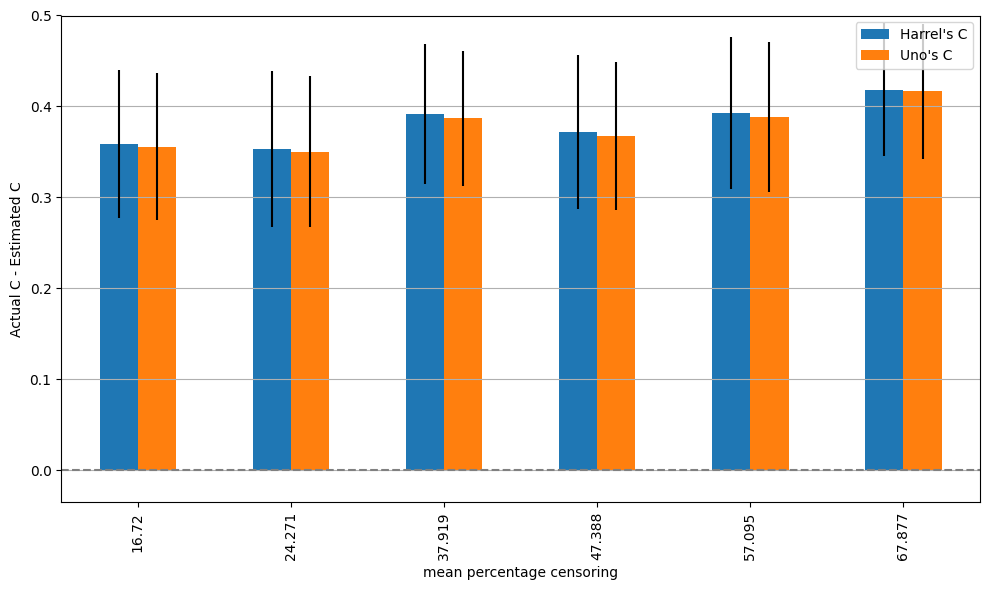

In [8]:
data_mean, data_std = simulation(n_samples=100, m=3, hazard_ratio=2.0)
ylim = [-0.035, 0.5]  # You can adjust this as needed
plot_results(data_mean, data_std, ylim=ylim, figsize=(10, 6))
